# Step 2: Model Fitting

In [1]:
# %pip install numpy --upgrade
# %pip install pandas --upgrade

from matplotlib import pyplot as plt
from typer_config import yaml_loader

from ddw import fit_model
from ddw.utils.print import pprint_dict, print_help_for_function_arguments


## Fitting a Model on the Tutorial Data

To fit a model on the tutorial data, we use the `fit-model` command of the `ddw` package. Sometimes, the commandline output is not properly displayed in Jupyter notebooks, so you might want to run the command in the next cell in the commandline rather than here.

**Note:** In this tutorial, we fit the model for 1000 epochs. However, reconstructions from earlier epochs should already look good. In our experiments, we found that although the fitting and validation loss continue to decrease with more epochs, the reconstructions are often relatively stationary after a certain number of epochs. 
You may want to check reconstructions during model fitting using intermediate checkpoints (see `Step3:TomogramRefinement.ipynb`). You can control the frequency of saving intermediate checkpoints using the `save_model_every_n_epochs` option of the `fit-model` command. 

**Note:**  On our system with a single NVIDIA L40 GPU (46068 MiB memory), an AMD EPYC 9334 CPU with 128 logical cores and 252 GB CPU RAM, fitting the model for this tutorial for 1000 epochs took approximately 14.5 hours. The time taken to fit the model will vary depending on the hardware you are using. 

In [4]:
!conda run --no-capture-output -n ddw_env ddw fit-model --config ./config.yaml

Global seed set to 42
Saving logs and model checkpoints to 'tutorial_project/logs/version_0'
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/bcache/work/a.omidvarnia/conda_envs/ddw_env/lib/python3.10/site-packages/ddw/utils/subtomo_dataset.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializatio

During fitting, model checkpoints (`.ckpt` files) and loss values are written to `tutorial_project/logs`. The model checkpoints are needed later for tomogram refinement in Step 3. Since for this tutorial, we are using the csv-logger (`logger=csv` in `./config.yaml`), loss values are available in a csv file, so we can plot the losses using `pandas` and `matplotlib`:

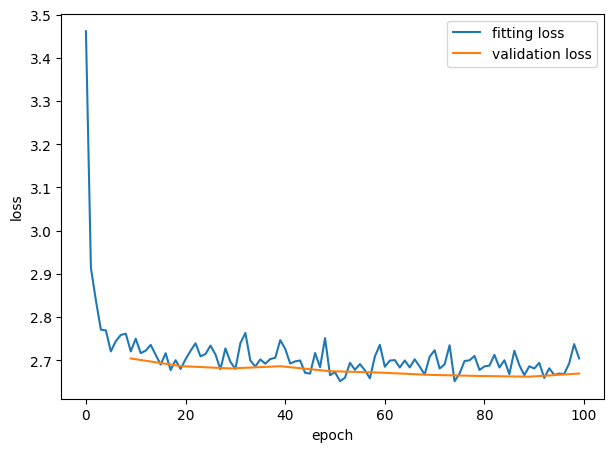

In [5]:
import pandas as pd
metrics = pd.read_csv(f"./tutorial_project/logs/version_0/metrics.csv")

plt.figure(figsize=(7,5))
plt.plot(metrics[~metrics.fitting_loss.isna()].epoch, metrics.fitting_loss[~metrics.fitting_loss.isna()], label="fitting loss")
plt.plot(metrics[~metrics.val_loss.isna()].epoch[1:], metrics.val_loss[~metrics.val_loss.isna()][1:], label="validation loss")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")

If you plan to do more systematic experiments with DeepDeWedge, we recommend using the more convenient TensorBoard logger by setting `logger=tensorboard` in the config file. For details on TensorBoard, and how to view the logs, please refer to the [official TensorBoard documentation](https://www.tensorflow.org/tensorboard/get_started).

## Most Important Parameters of `fit_model` 

You can find a full list of parameters for `ddw fit-model` by executing
```
conda run -n ddw_env ddw fit-model --help
```
in the commandline. Here, we only discuss the most important parameters. The required parameters, which cover the most relevant functionality for most users, are:

In [ ]:
print_help_for_function_arguments(fit_model, print_only_required=True)

The parameter `unet_params_dict` requires some more explanation. It is a dictionary that contains the parameters for the U-Net model. In our example, we use:

In [ ]:
config = yaml_loader("./config.yaml")
pprint_dict(config["fit_model"]["unet_params_dict"])

The meaning of the parameters is as follows:
- `chans`: Number of feature channels in the convolutionsal blocks before the first dowsampling layer.
- `num_downsample_layers`: Number of downsampling layers in the U-Net. After each downsampling layer, the number of feature channels is doubled.
- `drop_prob`: Dropout probability in the U-Net, we recommend setting this to 0.0 unless you observe overfitting.

To adjust the model complexity, we recommend changing the `chans` parameter. A higher value will increase the number of parameters in the model, but also the time consumption of model fitting. A lower value will decrease the number of parameters, but allows faster fitting.